created 10-26-23
#  <mark style="background-color: #C0C7Fb"> <font color ='#3365d3'> Build Idealized Model Bathymetry, Wind, and Sea Surface Temperature. </font></mark>

#  <mark style="background-color: #f99973"> <font color ='#f9e5c7'> Table of Contents. </font></mark>
1. **[Background](#1)**
2. **[Build Bathymetry](#2)** \
    a. [Check with plots](#2a)
3. **[Build Wind Forcing](#3)** \
    a. [Wind Equations](#3a) \
    b. [Check with plots](#3b)
4. **[Build Sea Surface Temperature](#4)** \
    a. [SST Equations](#4a) \
    b. [Check with plots](#4b)

#  <mark style="background-color: #f6c0d8"> <font color ='#f34c9d'> 1. Background. </font></mark>
<a name=1></a>

We would like to create bathymetry so that we can run an idealized model to study AMOC in the tropics. Since we want to investigate a specific location, we use an idealized model because MOM6 is a global model, not a regional model. We want to release particles in the idealized model to follow water parcels and its vertical and horizontal motion through the tropics. 

Bathymetry is built using the Neverworld2 package found [here](https://github.com/ocean-eddy-cpt/NeverWorld2/blob/main/docs/NeverWorld2.ipynb). Furhter information about Neverworld2 can be found [here](https://gmd.copernicus.org/articles/15/6567/2022/).

In order to use the `topo_builder` package, the `topo_builder.py` [script](https://github.com/kailauyeda/single_basin_amoc_tropics/blob/main/6-21_build_INPUT/topo_builder.py) must be in the same directory as this notebook. 

Full MOM6 forcing files for the single basin experiment are found in [`6-12_INPUT_figures`](https://github.com/kailauyeda/single_basin_amoc_tropics/blob/main/6-21_build_INPUT/6-12_INPUT_figures.ipynb).

## <font color='f34c9d'> Coordinate Explanation. </font>

|Data| Center| Corner|
|:--| :--:| :--:|
|MOM6| h| q|
|Neverworld2| c | g|
|Domain Size (y,x) | (140,80)|(141,81)|

In [56]:
import cartopy
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import scipy.interpolate
import xarray as xr
import netCDF4 as nc4
import cmocean.cm as cmo
import cmocean
import topo_builder # module retrieved from topo_builder.py from neverworld2 code imported to /home/jupyter-kuyeda

#  <mark style="background-color: #C0C7Fb"> <font color ='#3365d3'> 2. Build Bathymetry. </font></mark>
<a name=2></a>
Uses `NS_ridge` command to build ridge in middle of ocean. 

## <font color='3365d3'> Set Up Neverworld2 Domain. </font>

In [57]:
# NeverWorld2 domain
NW2_lonW, NW2_lonE = 0, 80
NW2_latS, NW2_latN = -70, 70

D0 = 4000 # Nominal depth (m)
cd = 200 # Depth of coastal shelf (m)
drake = 2500 # Depth of Drake sill (m)
cw = 5 # Width of coastal shelf (degrees)

# Logical domain (grid points)
nj, ni = 140, 80

In [58]:
for_ridge = topo_builder.topo(nj, ni, dlon=NW2_lonE, dlat=NW2_latN-NW2_latS, lat0=NW2_latS, D=D0)
for_ridge.add_NS_coast(NW2_lonW, -40, 90, cw, cd)
for_ridge.add_NS_coast(NW2_lonE, -40, 90, cw, cd)
for_ridge.add_NS_coast(NW2_lonW, -90, -60, cw, cd)
for_ridge.add_NS_coast(NW2_lonE, -90, -60, cw, cd)
for_ridge.add_EW_coast(-360, 360, NW2_latS, cw, cd)
for_ridge.add_EW_coast(-360, 360, NW2_latN, cw, cd)
for_ridge.add_NS_ridge(40, -70, 140, 30, D0/2) # Mid-Atlantic ridge?

In [59]:
ds = xr.Dataset()
xh = for_ridge.xc
yh = for_ridge.yc
xq = for_ridge.xg
yq = for_ridge.yg

## <font color='3365d3'> Prepare netcdf.</font>

In [60]:
import netCDF4 as nc4
f = nc4.Dataset('/vortex1/jupyter-kuyeda/files_to_delete/topo_file_test4.nc','w',format='NETCDF4')

In [61]:
try: ncfile.close()
except:pass
print(f)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: 


## <font color='3365d3'> Create dimensions. </font>

In [62]:
xh_dim = f.createDimension('xh',len(xh))
yh_dim = f.createDimension('yh',len(yh))
xq_dim = f.createDimension('xq',len(xq))
yq_dim = f.createDimension('yq',len(yq))
for dim in f.dimensions.items():
    print(dim)

('xh', <class 'netCDF4._netCDF4.Dimension'>: name = 'xh', size = 80)
('yh', <class 'netCDF4._netCDF4.Dimension'>: name = 'yh', size = 140)
('xq', <class 'netCDF4._netCDF4.Dimension'>: name = 'xq', size = 81)
('yq', <class 'netCDF4._netCDF4.Dimension'>: name = 'yq', size = 141)


## <font color='3365d3'> Create attributes.</font>

In [63]:
f.title='Neverworld2 test bathymetry'
print(f.title)

Neverworld2 test bathymetry


In [64]:
f.subtitle='subtitle'
print(f.subtitle)
print(f)

subtitle
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: Neverworld2 test bathymetry
    subtitle: subtitle
    dimensions(sizes): xh(80), yh(140), xq(81), yq(141)
    variables(dimensions): 
    groups: 


## <font color='3365d3'> Create variables. </font>

In [65]:
# coordinate variables
xh = f.createVariable('xh',np.float32,('xh'))
xh.units = 'degrees_east'
xh.long_name = 'longitude'

In [66]:
yh = f.createVariable('yh',np.float32,('yh'))
yh.units = 'degrees_north'
yh.long_name = 'latitude'

In [67]:
xq = f.createVariable('xq',np.float32,('xq'))
xq.units = 'degrees_east'
xq.long_name = 'longitude'

In [68]:
yq = f.createVariable('yq',np.float32,('yq'))
yq.units = 'degrees_north'
yq.long_name = 'latitude'

In [69]:
z = f.createVariable('z',np.float32,('yh','xh'))
z.long_name = 'field_depth'
z.units = 'm'
print(z)

<class 'netCDF4._netCDF4.Variable'>
float32 z(yh, xh)
    long_name: field_depth
    units: m
unlimited dimensions: 
current shape = (140, 80)
filling on, default _FillValue of 9.969209968386869e+36 used


In [70]:
z[:,:]=-for_ridge.z

In [71]:
print("-- Min/Max values:",z[:,:].min(),z[:,:].max())

-- Min/Max values: 0.0 4000.0


In [72]:
xh[:]= for_ridge.xc
# print(xh[:])
# print(xh.units)

In [73]:
yh[:]= for_ridge.yc
# print(yh[:])
# print(yh.units)

In [74]:
xq[:]= for_ridge.xg
# print([xq[:]])
# print(xq.units)

In [75]:
yq[:]= for_ridge.yg
# print(yq[:])
# print(yq.units)

In [76]:
print(f)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: Neverworld2 test bathymetry
    subtitle: subtitle
    dimensions(sizes): xh(80), yh(140), xq(81), yq(141)
    variables(dimensions): float32 xh(xh), float32 yh(yh), float32 xq(xq), float32 yq(yq), float32 z(yh, xh)
    groups: 


In [77]:
f.close(); print('dataset is closed')

dataset is closed


## <font color='3365d3'> 2a. Check with plots. </font>
<a name=2a></a>
`actual` is the dataset created that is used in the simulations.\
`sample` is any additional dataset created for demonstration purposes.

In [78]:
bath_actual = xr.open_dataset('/vortex1/jupyter-kuyeda/t_m_p_wind/6-21_build_INPUT/6-21_INPUT_files/topo_file_test1.nc')
bath_sample = xr.open_dataset('/vortex1/jupyter-kuyeda/files_to_delete/topo_file_test4.nc')

Text(0.5, 0, 'Longitude ($^{\\circ}$E)')

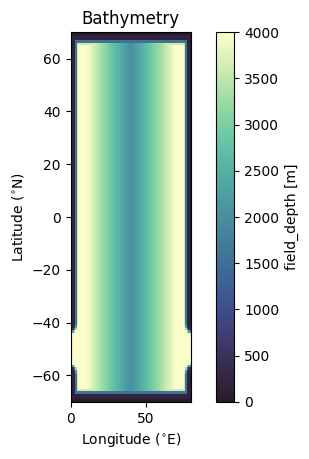

In [201]:
fig,ax = plt.subplots(nrows=1,ncols=1)
bathmap = cmocean.tools.crop(cmocean.cm.topo,0,2000,2000)
bath_sample.z.plot(cmap=bathmap)
ax.set_aspect(140/80)
ax.set_title('Bathymetry')
ax.set_ylabel('Latitude ($^{\circ}$N)')
ax.set_xlabel('Longitude ($^{\circ}$E)')

#  <mark style="background-color: #f99973"> <font color ='#f9e5c7'> 3. Build Wind Forcing.  </font></mark>
<a name=3></a>
We will build out the `bathymetry` file we just created because the dimensions `xh`, `yh`, `xq`, `yq` are already defined. 

## <font color="f99973"> Prepare netcdf.</font>

In [80]:
import netCDF4 as nc4
f1 = nc4.Dataset('/vortex1/jupyter-kuyeda/files_to_delete/wind_sample_nov_10_1.nc','w',format='NETCDF4')

In [81]:
try: ncfile.close()
except:pass
print(f1)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: 


## <font color="f99973"> Create dimensions.</font>

We want wind to have $(yh,xh)$ coordinates, which correspond to $(yc,xc)$ in Neverworld2. Since these coordinates sit in the middle of the grid cell, we delete the first row (`for_ridge.yg`) and first column (`for_ridge.xg`) since they are located at the corners of the grid cell (not the middle). Otherwise, the first row and first column would extend beyond the $(yh,xh)$ grid. 

In [82]:
np.delete(for_ridge.yg,obj=0,axis=0)

array([-69., -68., -67., -66., -65., -64., -63., -62., -61., -60., -59.,
       -58., -57., -56., -55., -54., -53., -52., -51., -50., -49., -48.,
       -47., -46., -45., -44., -43., -42., -41., -40., -39., -38., -37.,
       -36., -35., -34., -33., -32., -31., -30., -29., -28., -27., -26.,
       -25., -24., -23., -22., -21., -20., -19., -18., -17., -16., -15.,
       -14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,
        -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,
         8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,
        19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,
        30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,
        41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,
        52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,
        63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.])

In [83]:
xh = for_ridge.xc
yh = for_ridge.yc
xq = np.delete(for_ridge.xg,obj=0,axis=0)
yq = np.delete(for_ridge.yg,obj=0,axis=0)

In [84]:
xh_dim = f1.createDimension('xh',len(xh))
yh_dim = f1.createDimension('yh',len(yh))
xq_dim = f1.createDimension('xq',len(xq))
yq_dim = f1.createDimension('yq',len(yq))
for dim in f1.dimensions.items():
    print(dim)

('xh', <class 'netCDF4._netCDF4.Dimension'>: name = 'xh', size = 80)
('yh', <class 'netCDF4._netCDF4.Dimension'>: name = 'yh', size = 140)
('xq', <class 'netCDF4._netCDF4.Dimension'>: name = 'xq', size = 80)
('yq', <class 'netCDF4._netCDF4.Dimension'>: name = 'yq', size = 140)


## <font color="f99973"> Create attributes. </font>

In [85]:
f1.title='wind forcing test'
print(f1.title)

wind forcing test


In [86]:
f1.subtitle='subtitle'
print(f1.subtitle)
print(f1)

subtitle
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: wind forcing test
    subtitle: subtitle
    dimensions(sizes): xh(80), yh(140), xq(80), yq(140)
    variables(dimensions): 
    groups: 


## <font color="f99973"> Create variables. </font>

In [87]:
# coordinate variables
xh = f1.createVariable('xh',np.float32,('xh'))
xh.units = 'degrees_east'
xh.long_name = 'longitude'

In [88]:
yh = f1.createVariable('yh',np.float32,('yh'))
yh.units = 'degrees_north'
yh.long_name = 'latitude'

In [89]:
xq = f1.createVariable('xq',np.float32,('xq'))
xq.units = 'degrees_east'
xq.long_name = 'longitude'

In [90]:
yq = f1.createVariable('yq',np.float32,('yq'))
yq.units = 'degrees_north'
yq.long_name = 'latitude'

In [91]:
taux = f1.createVariable('taux',np.float32,('yh','xq'))
taux.long_name = 'zonal surface wind forcing'
taux.units = 'Pa'
print(taux)

<class 'netCDF4._netCDF4.Variable'>
float32 taux(yh, xq)
    long_name: zonal surface wind forcing
    units: Pa
unlimited dimensions: 
current shape = (140, 80)
filling on, default _FillValue of 9.969209968386869e+36 used


In [92]:
tauy = f1.createVariable('tauy',np.float32,('yq','xh'))
tauy.long_name = 'meridional surface wind forcing'
tauy.units = 'Pa'
print(tauy)

<class 'netCDF4._netCDF4.Variable'>
float32 tauy(yq, xh)
    long_name: meridional surface wind forcing
    units: Pa
unlimited dimensions: 
current shape = (140, 80)
filling on, default _FillValue of 9.969209968386869e+36 used


## <font color="f99973"> Assign variables. </font>

In [93]:
xh[:]= for_ridge.xc
# print(xh[:])
# print(xh.units)

In [94]:
yh[:]= for_ridge.yc
# print(yh[:])
# print(yh.units)

In [95]:
xq[:]= np.delete(for_ridge.xg,obj=0,axis=0)
# print([xq[:]])
# print(xq.shape)

In [96]:
yq[:]= np.delete(for_ridge.yg,obj=0,axis=0)
# print(yq[:])
# print(yq.units)
# print(yq.shape)

## <font color="f99973"> 3a. Create an array of valeus for $\tau_x$ and $\tau_y$. </font>
<a name=3a></a>

$$ 
\begin{align}
\tau_x &= \tau_{max} \left[ - cos\left(\frac{3 \pi \varphi}{140}\right) + e^{-\varphi^2 / \sigma^2} \right] \\
\tau_y &= 0 \\
\text{where } &\tau_{max} = 0.1\text{   Pa,   } \varphi =  \text{ longitude, &   }  \sigma=10^{\circ}
\end{align}
$$

In [97]:
# calculate the taux (yh,xq) (140,81) for every value
tau_max = 0.1 # max wind
sigma = 10    # 10 deg
yh = for_ridge.yc

windxh = tau_max*(-np.cos(3*np.pi*yh/140) + np.exp((-yh**2)/sigma**2))
windxh.shape

(140,)

In [98]:
# manually create a taux (yq,xh) (140,80) size array for taux(yh,xq)

# assign every cell in the array to a windyh value 
    # create a (140,81) numpy array
ones = np.ones((140,80))
ones.shape

    # assign the windyh.shape = (140,) values to every column in the new array
taux_np=ones * windxh[:,np.newaxis]

    # MOM6 counts cells right to left, so we have xq values that extend beyond the domain. 
    # We need to remove the xq value on the opposite side of the cell, so we remove the first column of taux_np
#taux_np = np.delete(taux_np, obj=0, axis=1)
taux_np.shape
#taux_np[:,1]

(140, 80)

In [99]:
# manually create a (140,80) size array for tauy

tauy_np = np.zeros((140,80))

# same as above, MOM6 counts cells top to bottom, so we have yq values that extend beyond the domain.
# We need to remove the yq value on the opposite side of the cell, so we remove the last row of tauy_np

#tauy_np = np.delete(tauy_np,obj=-1,axis=0)
tauy_np.shape

(140, 80)

In [100]:
taux[:] = taux_np
# print(taux[:])
# print(taux.units)
# print(taux.shape)

In [101]:
tauy[:] = tauy_np
# print(tauy[:])
# print(tauy.units)
# print(tauy.shape)

## <font color="f99973"> Close out file. </font>

In [102]:
print(f1)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: wind forcing test
    subtitle: subtitle
    dimensions(sizes): xh(80), yh(140), xq(80), yq(140)
    variables(dimensions): float32 xh(xh), float32 yh(yh), float32 xq(xq), float32 yq(yq), float32 taux(yh, xq), float32 tauy(yq, xh)
    groups: 


In [103]:
f1.close(); print('dataset is closed')

dataset is closed


## <font color="f99973"> 3b. Check file with plots.  </font>
<a name=3b></a>

`actual` is the dataset created that is used in the simulations.\
`sample` is any additional dataset created for demonstration purposes.

In [104]:
wind_actual = xr.open_dataset('/vortex1/jupyter-kuyeda/t_m_p_wind/6-21_build_INPUT/6-21_INPUT_files/wind_sample_nov_10.nc')
wind_sample = xr.open_dataset('/vortex1/jupyter-kuyeda/files_to_delete/wind_sample_nov_10_1.nc')

Text(0.5, 1.1, 'Wind Forcing')

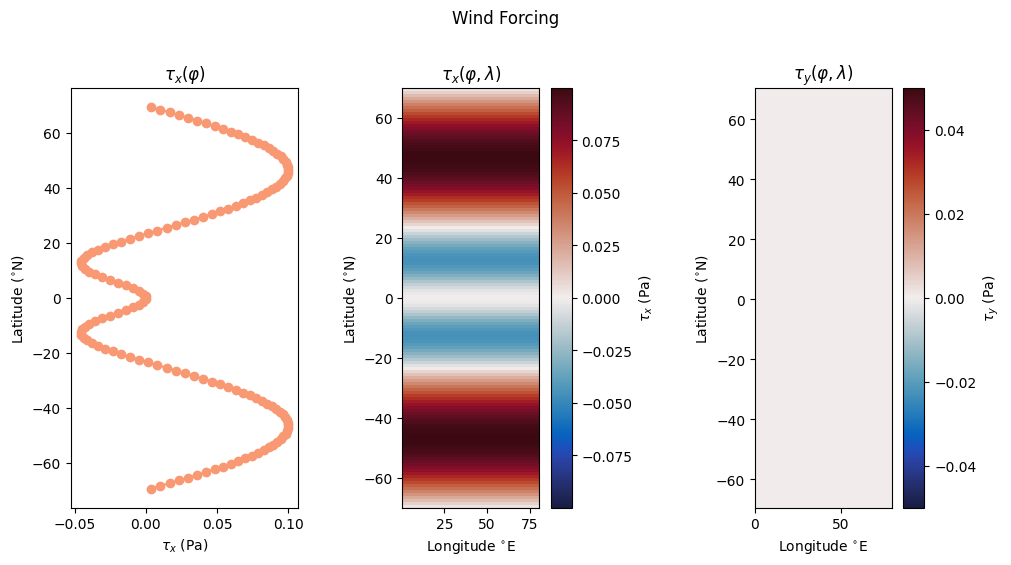

In [202]:
fig,ax = plt.subplots(nrows=1,ncols=3,constrained_layout=True,figsize=(10,5))
wind_sample.taux.mean('xq').plot(y='yh',color='#f99973',ax=ax[0],marker='o')
wind_sample.taux.plot(cmap=cmocean.cm.balance ,ax=ax[1],cbar_kwargs={'label':'$\\tau_x$ (Pa)'})
wind_sample.tauy.plot(cmap=cmocean.cm.balance,ax=ax[2],cbar_kwargs={'label':'$\\tau_y$ (Pa)'})

ax[0].set_xlabel('$\\tau_x$ (Pa)')
ax[0].set_title('$\\tau_x (\\varphi)$')
 
ax[1].set_aspect(140/80)
ax[1].set_xlabel('Longitude $^{\circ}$E')
ax[1].set_title('$\\tau_x (\\varphi,\lambda)$')
                                                          
ax[2].set_aspect(140/80)
ax[2].set_xlabel('Longitude $^{\circ}$E')
ax[2].set_title('$\\tau_y (\\varphi,\\lambda)$')                                                          

for i in range(0,3):
    ax[i].set_ylabel('Latitude ($^{\circ}$N)')
    
fig.suptitle('Wind Forcing',y=1.1)

#  <mark style="background-color: #f6c0d8"> <font color ='#f34c9d'> 4. Build Temperature Forcing. </font></mark>
<a name=4></a>

We will use the same method as the wind forcing file.

In [155]:
import netCDF4 as nc4
f2 = nc4.Dataset('/vortex1/jupyter-kuyeda/files_to_delete/temp_sample_nov_10_3.nc','w',format='NETCDF4')

In [156]:
try: ncfile.close()
except:pass
print(f2)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: 


## <font color="f34c9d"> Create dimensions. </font>

In [157]:
np.delete(for_ridge.yg,obj=0,axis=0)

array([-69., -68., -67., -66., -65., -64., -63., -62., -61., -60., -59.,
       -58., -57., -56., -55., -54., -53., -52., -51., -50., -49., -48.,
       -47., -46., -45., -44., -43., -42., -41., -40., -39., -38., -37.,
       -36., -35., -34., -33., -32., -31., -30., -29., -28., -27., -26.,
       -25., -24., -23., -22., -21., -20., -19., -18., -17., -16., -15.,
       -14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,
        -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,
         8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,
        19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,
        30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,
        41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,
        52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,
        63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.])

In [158]:
xh = for_ridge.xc
yh = for_ridge.yc
xq = np.delete(for_ridge.xg,obj=0,axis=0)
yq = np.delete(for_ridge.yg,obj=0,axis=0)

In [159]:
xh_dim = f2.createDimension('xh',len(xh))
yh_dim = f2.createDimension('yh',len(yh))
xq_dim = f2.createDimension('xq',len(xq))
yq_dim = f2.createDimension('yq',len(yq))
for dim in f2.dimensions.items():
    print(dim)

('xh', <class 'netCDF4._netCDF4.Dimension'>: name = 'xh', size = 80)
('yh', <class 'netCDF4._netCDF4.Dimension'>: name = 'yh', size = 140)
('xq', <class 'netCDF4._netCDF4.Dimension'>: name = 'xq', size = 80)
('yq', <class 'netCDF4._netCDF4.Dimension'>: name = 'yq', size = 140)


## <font color="f34c9d"> Create attributes. </font>

In [160]:
f2.title='surface temp forcing test'
print(f2.title)

surface temp forcing test


In [161]:
f2.subtitle='deg_celsius'
print(f2.subtitle)
print(f2)

deg_celsius
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: surface temp forcing test
    subtitle: deg_celsius
    dimensions(sizes): xh(80), yh(140), xq(80), yq(140)
    variables(dimensions): 
    groups: 


## <font color="f34c9d"> Create variables. </font>

In [162]:
# coordinate variables
xh = f2.createVariable('xh',np.float32,('xh'))
xh.units = 'degrees_east'
xh.long_name = 'longitude'

In [163]:
yh = f2.createVariable('yh',np.float32,('yh'))
yh.units = 'degrees_north'
yh.long_name = 'latitude'

In [164]:
xq = f2.createVariable('xq',np.float32,('xq'))
xq.units = 'degrees_east'
xq.long_name = 'longitude'

In [165]:
yq = f2.createVariable('yq',np.float32,('yq'))
yq.units = 'degrees_north'
yq.long_name = 'latitude'

In [166]:
temp = f2.createVariable('SST',np.float32,('yh','xh'))
temp.long_name = 'surface temperature forcing'
temp.units = 'deg_Celsius'
print(surf_temp)

<class 'netCDF4._netCDF4.Variable'>
float32 surf_temp(yh, xh)
    long_name: surface temperature forcing
    units: deg_Celsius
unlimited dimensions: 
current shape = (140, 80)
filling on, default _FillValue of 9.969209968386869e+36 used


## <font color="f34c9d"> Assign variables. </font>

In [167]:
xh[:]= for_ridge.xc
# print(xh[:])
# print(xh.units)

In [168]:
yh[:]= for_ridge.yc
# print(yh[:])
# print(yh.units)

In [169]:
xq[:]= np.delete(for_ridge.xg,obj=0,axis=0)
# print([xq[:]])
# print(xq.shape)

In [170]:
yq[:]= np.delete(for_ridge.yg,obj=0,axis=0)
# print(yq[:])
# print(yq.units)
# print(yq.shape)

## <font color="f34c9d"> 4a. Create an array of values for `SST`. </font>
<a name=4a></a>

$$
\begin{align}
T &= T_{eq}\left[cos\left(\frac{\pi \varphi}{140}\right)^2 + 0.1e^{-\left(\frac{\varphi}{2\Theta} -1\right)^2} \right] \\
\text{where } &T_{eq} = 25{^\circ}C \text{ , } \varphi = \text{ latitude, and } \Theta = 60^{\circ}
\end{align}
$$


In [171]:
# calculate the surf_temp (yh,xh) (140,80) for every value
yq = np.delete(for_ridge.yg,obj=0,axis=0)
Teq = 25   
theta = 60

#numpy cosine is in radians

term_1 = (np.cos(yq*np.pi/140))**2
exp = -((yq/(2*theta))-1)**2
term_2 = 0.1*np.exp(exp)

temp_np = Teq*(term_1 + term_2)

In [173]:
# plt.plot(term_1,marker='o')
# plt.plot(yh,marker='x')

In [174]:
# manually create a temp (yh,xh) (140,80) size array for temp(yh,xh)

# assign every cell in the array to a surf_temp value 
    # create a (140,80) numpy array
ones = np.ones((140,80))
ones.shape

# assign the windyh.shape = (140,) values to every column in the new array
temp_np=ones * temp_np[:,np.newaxis]

temp_np.shape


(140, 80)

In [175]:
temp[:] = temp_np
# print(surf_temp[:])
# print(surf_temp.units)
# print(surf_temp.shape)

## <font color="f34c9d"> Close out file. </font>

In [176]:
print(f2)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: surface temp forcing test
    subtitle: deg_celsius
    dimensions(sizes): xh(80), yh(140), xq(80), yq(140)
    variables(dimensions): float32 xh(xh), float32 yh(yh), float32 xq(xq), float32 yq(yq), float32 SST(yh, xh)
    groups: 


In [177]:
f2.close(); print('dataset is closed')

dataset is closed


## <font color="f34c9d"> 4b. Check file with plots. </font>
<a name=4b></a>

`actual` is the dataset created that is used in the simulations.\
`sample` is any additional dataset created for demonstration purposes.

In [180]:
temp_actual = xr.open_dataset('/vortex1/jupyter-kuyeda/t_m_p_wind/6-21_build_INPUT/6-21_INPUT_files/11-27_NaN_SST.nc')
temp_sample = xr.open_dataset('/vortex1/jupyter-kuyeda/files_to_delete/temp_sample_nov_10_3.nc')

Text(0.5, 0.98, 'Sea Surface Temperature Forcing')

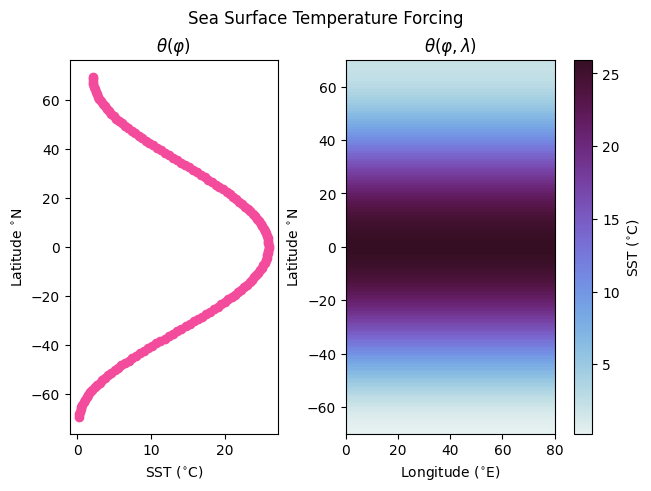

In [203]:
fig,ax = plt.subplots(nrows=1,ncols=2,constrained_layout=True)
temp_sample.SST.mean(dim='xh').plot(ax=ax[0],marker='o',y='yh',color='#f34c9d')
temp_sample.SST.plot(ax=ax[1],cmap=cmocean.cm.dense,cbar_kwargs={'label':'SST ($^{\circ}$C)'})

ax[0].set_title('$\\theta (\\varphi)$')
ax[0].set_xlabel('SST ($^{\circ}$C)')

ax[1].set_title('$\\theta (\\varphi, \\lambda)$')
ax[1].set_xlabel('Longitude ($^{\circ}$E)')


for i in range(0,2):
    ax[i].set_ylabel('Latitude $^{\circ}$N')

fig.suptitle('Sea Surface Temperature Forcing')